In [15]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import (ImageDataGenerator, 
                                                  array_to_img, img_to_array, 
                                                  load_img) 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.image as mpimg
import pathlib
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, Xception, InceptionV3
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.utils import plot_model


from datetime import datetime
import datetime
import time
from tensorflow.math import confusion_matrix
from tensorflow.keras.preprocessing import image 
plt.style.use("ggplot")

from src.build_models import *
from src.plotting_funcs import *
# from src.predict_funcs import *

In [7]:
train_generator229, validation_generator229 = create_data_gens(target_size=(229,229), train_dir = "../images/Images/train",  val_dir = '../images/Images/test', batch_size = 30)

train_generator, validation_generator = create_data_gens(target_size=(150,150), train_dir = "../images/Images/train",  val_dir = '../images/Images/test', batch_size = 30)

Found 4164 images belonging to 25 classes.
Found 185 images belonging to 25 classes.
Found 4164 images belonging to 25 classes.
Found 185 images belonging to 25 classes.


## Basic CNN

In [57]:
cnn_mod = load_model('models_and_weights/models/first_try_basiccnn150.h5')
loss1, acc1, top_k_acc1 = cnn_mod.evaluate(validation_generator)

In [74]:
print_model_properties(cnn_mod)

Layer 0 | Name: conv2d | Trainable: True
Layer 1 | Name: activation | Trainable: True
Layer 2 | Name: max_pooling2d | Trainable: True
Layer 3 | Name: conv2d_1 | Trainable: True
Layer 4 | Name: activation_1 | Trainable: True
Layer 5 | Name: max_pooling2d_1 | Trainable: True
Layer 6 | Name: conv2d_2 | Trainable: True
Layer 7 | Name: activation_2 | Trainable: True
Layer 8 | Name: max_pooling2d_2 | Trainable: True
Layer 9 | Name: flatten | Trainable: True
Layer 10 | Name: dense | Trainable: True
Layer 11 | Name: activation_3 | Trainable: True
Layer 12 | Name: dropout | Trainable: True
Layer 13 | Name: dense_1 | Trainable: True
Layer 14 | Name: activation_4 | Trainable: True


## Xception Models

In [4]:
x_mod_150 = load_model('models_and_weights/models/Xception_mod150.h5')
loss2, acc2, top_k_acc2 = x_mod_150.evaluate(validation_generator)

1/1 [==============================] - 9s 9s/step - loss: 5.3634 - accuracy: 0.7405 - top_k_categorical_accuracy: 0.9081


In [5]:
plus_20_x_mod_150 = load_model('models_and_weights/models/plus_20_Xception_mod150.h5')
loss3, acc3, top_k_acc3 = plus_20_x_mod_150.evaluate(validation_generator)

1/1 [==============================] - 9s 9s/step - loss: 1.7623 - accuracy: 0.8108 - top_k_categorical_accuracy: 0.9514


##### Switch TO 229 target size

In [6]:
Xception_mod_229 = load_model('models_and_weights/models/Xception_mod3.h5')
loss4, acc4, top_k_acc4 = Xception_mod_229.evaluate(validation_generator229)

1/1 [==============================] - 19s 19s/step - loss: 1.0689 - accuracy: 0.8973 - top_k_categorical_accuracy: 0.9892


In [ ]:
#split next two cells to avoid crashing...BEST MODEL

In [2]:
Xception_mod_229_final = load_model('models_and_weights/models/Xception_mod3_run2.h5')

In [8]:
loss5, acc5, top_k_acc5 = Xception_mod_229_final.evaluate(validation_generator229)

1/1 [==============================] - 18s 18s/step - loss: 0.1167 - accuracy: 0.9730 - top_k_categorical_accuracy: 0.9946


## VGG16 Models

In [9]:
#150,150
first_VGG16 = load_model('models_and_weights/models/18vgg16.h5')
loss6, acc6 = first_VGG16.evaluate(validation_generator)

1/1 [==============================] - 14s 14s/step - loss: 2.2263 - accuracy: 0.3297


## ResNet Models

In [10]:
#229,229
first_resnet = load_model('models_and_weights/models/resnet.h5')
loss7, acc7= first_resnet.evaluate(validation_generator229)

1/1 [==============================] - 16s 16s/step - loss: 3.8665 - accuracy: 0.0703


In [58]:
#150,150
first_resnet150 = load_model('models_and_weights/models/resnet150.h5')
loss8, acc8, top_k_acc8= first_resnet150.evaluate(validation_generator)

1/1 [==============================] - 24s 24s/step - loss: 3.5951 - accuracy: 0.0595 - top_k_categorical_accuracy: 0.2216


## Plot Models

In [67]:
losses = [loss1, loss8, loss7, loss6, loss2, loss3, loss4, loss5]
normalized_loss = (losses - min(losses))/(max(losses)-min(losses))

In [73]:

x = np.arange(0, 10, 0.1)
y1 = 0.05 * x**2
y2 = -1 *y1

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')

plt.show()

array([0.52266256, 0.66297531, 0.71470921, 0.40208519, 1.        ,
       0.3136402 , 0.18148323, 0.        ])

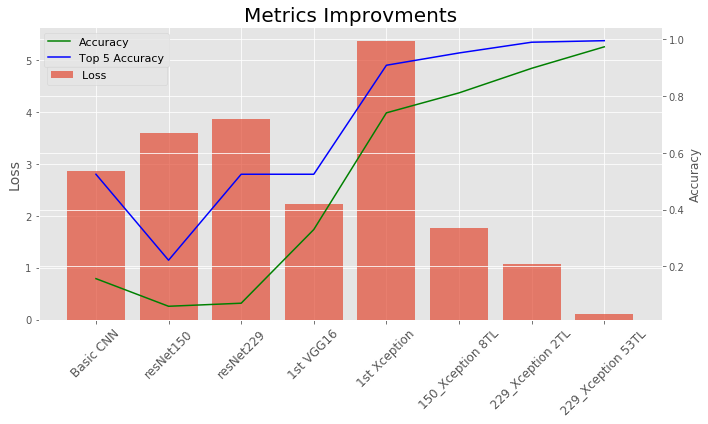

'\nfirst three Transfer Learning Models were trained on 10 epochs utilizing the minimum number of\ntrainable features Did not include top_k_accuracy for ResNet and VGG16\n'

In [152]:
models_descripts = ['Basic CNN','resNet150', 'resNet229', '1st VGG16',
                    '1st Xception', '150_Xception 8TL', '229_Xception 2TL', 
                    '229_Xception 53TL']

losses = [loss1, loss8, loss7, loss6, loss2, loss3, loss4, loss5]
# normalized_loss = (losses - min(losses))/(max(losses)-min(losses))

accuracys = [acc1, acc8, acc7, acc6, acc2, acc3, acc4, acc5]
top_ks = [top_k_acc1, top_k_acc8, top_k_acc1,top_k_acc1, top_k_acc2, top_k_acc3, top_k_acc4, top_k_acc5]

fig, ax2 = plt.subplots(figsize = (10,6))
ax1 = ax2.twinx()
x = np.arange(1,9)
ax2.bar(x, losses, label = 'Loss                ', alpha = 0.7)
ax1.plot(x, accuracys, label = 'Accuracy', color = 'g')
ax1.plot(x, top_ks, label = 'Top 5 Accuracy', color = 'b')
ax1.set_xticks(x)
ax2.set_xticklabels(models_descripts, rotation = 45,  fontsize = 12)
ax2.set_ylabel('Loss', fontsize = 14)
ax1.set_ylabel('Accuracy')
ax1.legend(fontsize = 11)
ax2.legend(fontsize = 11, bbox_to_anchor=(0.25,0.85),  bbox_transform=fig.transFigure)
plt.title('Metrics Improvments', fontsize = 20)
plt.tight_layout()
# plt.savefig('visuals/model_improvements.png')
plt.show();

'''
first three Transfer Learning Models were trained on 10 epochs utilizing the minimum number of
trainable features Did not include top_k_accuracy for ResNet and VGG16
'''

## Predict Using Best Model

In [21]:
predictions = Xception_mod_229_final.predict(validation_generator229)

True- Chihuahua, 
Pred- Pekinese

True- Blenheim_spaniel, 
Pred- whippet

True- papillon, 
Pred- Japanese_spaniel

True- Rhodesian_ridgeback, 
Pred- bloodhound

True- Boston_bull, 
Pred- pug



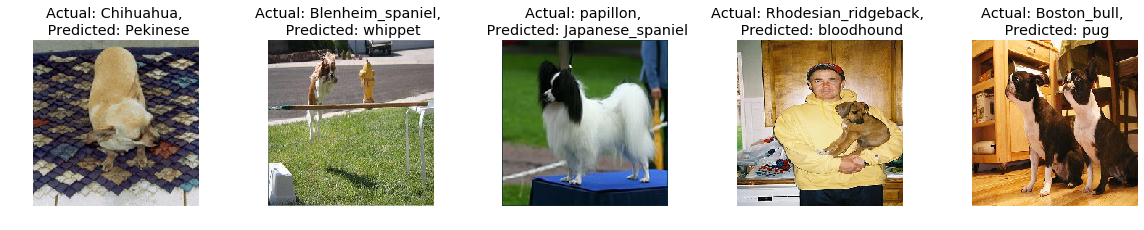

In [35]:
fig, axs = plt.subplots(1,5, figsize = (16,8))
plot_missclass1(validation_generator229, predictions, axs = axs)
plt.tight_layout()
# plt.savefig('visuals/wrong_pred.png');

#### Confusion Matrix Visual

In [338]:
predicted_class_indices = np.argmax(predictions,axis=1)

labels = validation_generator229.class_indices
labels = dict((v,k) for k,v in labels.items())
lst = list(labels.values())
real_labels = ['-'.join(lab.split('-')[1:]) for lab in lst]

df_cm = pd.DataFrame(confusion_arr, index = [i for i in real_labels],
              columns = [i for i in real_labels])
df_cm = df_cm/df_cm[df_cm.columns].sum()
df_cm[df_cm == 0] = np.nan

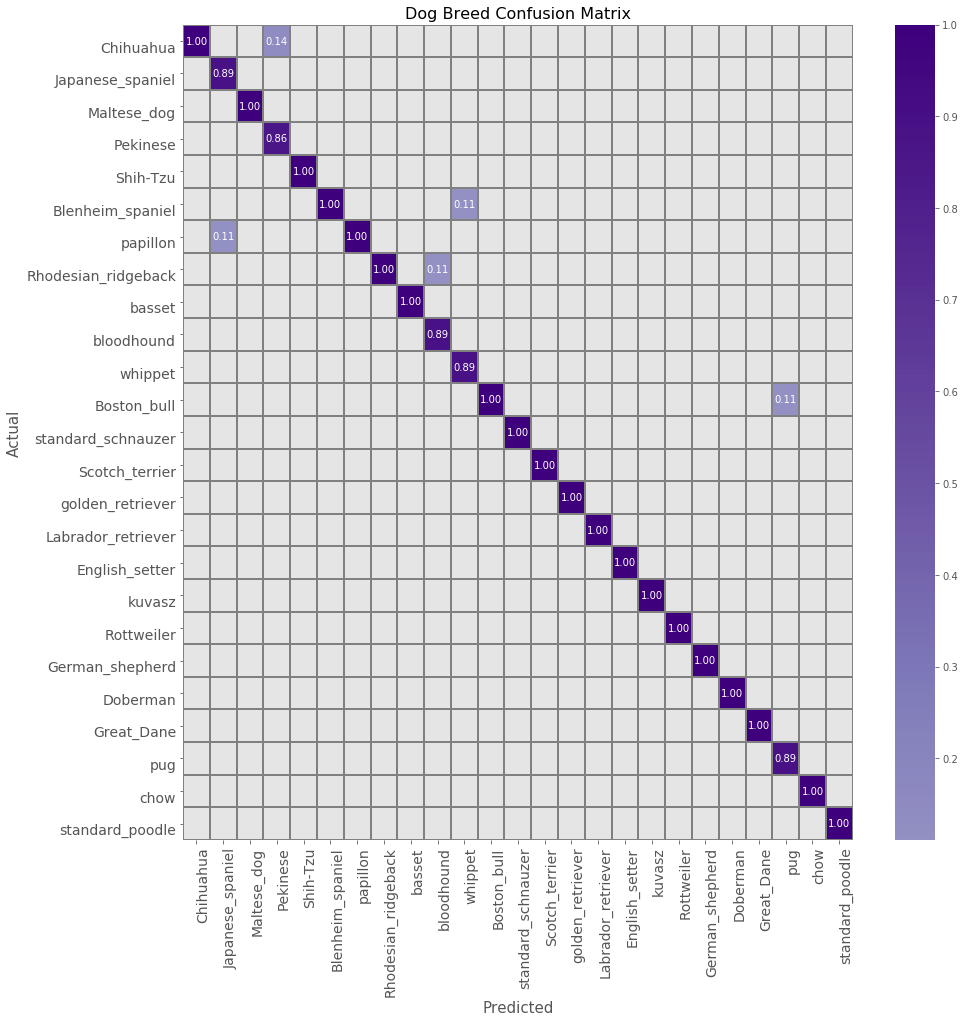

In [388]:
f_size = 14
fig, ax = plt.subplots(1, figsize = (15,15))
 
sns.heatmap(df_cm, annot=True, cmap='Purples', ax = ax, fmt='.2f', cbar=True, center = 0.02, linewidths=1, linecolor='grey' )
ax.set_title('Dog Breed Confusion Matrix', fontsize=16)
ax.set_xlabel('Predicted', fontsize=15)
ax.set_ylabel('Actual', fontsize=15)
ax.set_xticklabels(real_labels, rotation=90, fontsize=f_size, ha='left')
ax.set_yticklabels(real_labels, fontsize=f_size, va = 'top')
# for t in ax.texts: 
#     t.set_text(t.get_text() + " %")
    
plt.savefig('visuals/confusion_mtx.png')
plt.show();

#### Create visuals to compare misslabeled to dogs of that label

In [39]:
pred_labels, real_labels = get_real_pred(predictions, validation_generator229)
incorrect_inxes = find_missclass_indx(real_labels, pred_labels)

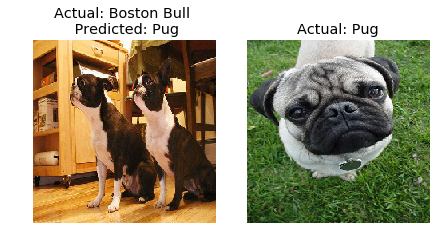

In [244]:
imgs, labs = validation_generator229.next()
fig, axs = plt.subplots(1,2)
ax = axs.flatten()
for i, indx in enumerate([incorrect_inxes[4], 162]):
    ax[i].imshow(imgs[indx])
    ax[i].axis('off')
    ax[i].set_title('Actual: Boston Bull \n Predicted: Pug');

plt.tight_layout(pad = 1/2)
plt.title('Actual: Pug')
# plt.savefig('fifth_missclass.png')
plt.show();

## Predict My Mutt

In [3]:
rees_dir = '../../../animal_images/just_rees'

In [4]:
pred_datagen = ImageDataGenerator(rescale=1./255)

# this is a similar generator, for validation data
pred_generator = pred_datagen.flow_from_directory(
        rees_dir,
        target_size=(229,229),
        batch_size=37,
        class_mode='categorical',
        shuffle = False,
        seed = 42)

Found 27 images belonging to 1 classes.


In [5]:
Rees_preds = Xception_mod_229_final.predict(pred_generator)
imgs, label = pred_generator.next()

In [8]:
labels = validation_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
rees_index = Rees_preds[0].argsort()[::-1]

In [11]:
final_preds = []
for img in range(len(imgs)):
    labels = validation_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())
    rees_index = Rees_preds[img].argsort()[::-1]
    label = labels[rees_index[0]]
    final_preds.append(('-'.join(label.split('-')[1:])))
    
rees_dict = {}
for items in final_preds:
    if items not in rees_dict:
        rees_dict[items] = 1
    else:
        rees_dict[items] += 1
        
counts = np.array(list(rees_dict.values()))
rees_labels = list(rees_dict.keys())
count_index = counts.argsort()[::-1]
Rees_order = [rees_labels[i] for i in count_index]

In [31]:
top_five = Rees_order[:5]

In [19]:
plt.style.use("dark_background")

In [48]:
def show_imgs(direct, num_imgs=20, figsize=(18,18)):
    images = os.listdir(direct)[:num_imgs]
    fig, axs = plt.subplots(1, 5, figsize=figsize)
    ax = axs.flatten()
    for i in range(num_imgs):
        #connect directory to selected breed path and image number
        img = mpimg.imread(direct + '/'+ images[i])
        ax[i].imshow(img)
        ax[i].axis('off')

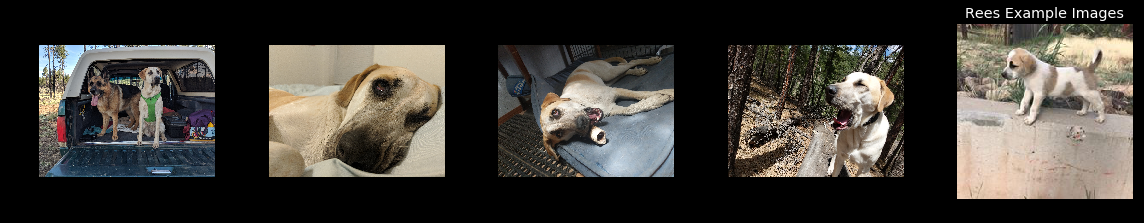

In [55]:
show_imgs('../../../animal_images/just_rees/just_five', num_imgs=5, figsize=(16,3))
plt.tight_layout()
# plt.title('Rees Example Images')
plt.savefig('visuals/animal_imgs/five_rees.png')

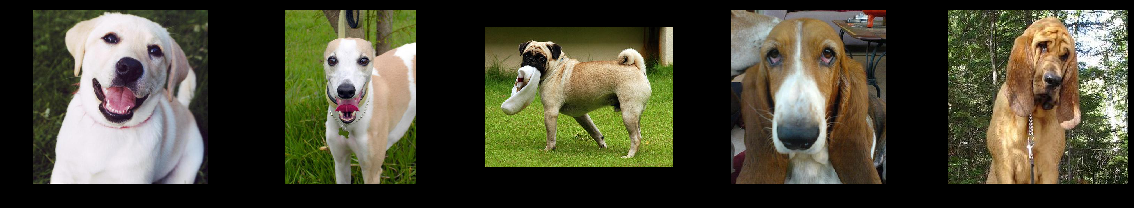

In [56]:
show_imgs('../../../animal_images/rees_top_five', num_imgs=5, figsize=(16,3))
# plt.title(top_five, loc = 'right')
plt.tight_layout()
plt.savefig('visuals/animal_imgs/top_five.png')